# BERT BASE MODEL DEVELOPMENT
Base model for binary and multiclassification against the NLTK corpus

### SETUP & LOAD DATA

In [46]:
!pip install tensorflow-datasets --quiet
!pip install tensorflow-text --quiet
!pip install pydot --quiet
!pip install nltk --quiet
!pip install transformers --quiet
!pip install pyarrow -quiet


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


In [47]:


import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import random
import re

nltk.download('gutenberg')
from nltk.corpus import gutenberg

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

#from google.colab import drive

import pyarrow as pya
import pyarrow.parquet as pq

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Dragon\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dragon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Mount drive to retrieve data frame
drive.mount('/content/drive')

In [48]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

# bert-base-cased
# bert-large-uncased
#checkpoint = 'bert-base-uncased'
checkpoint = 'bert-large-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

In [49]:
MAX_SEQUENCE_LENGTH = 128
DATA_LOC = 'local'  # set to local or remote

In [50]:
def create_bert_cnn(model,
                    num_train_layers=0,
                    num_classes=2,
                    hidden_size=50,
                    dropout=0.1,
                    learning_rate=0.001,
                    lr_scheduler=False):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
      # Freeze all layers of pre-trained BERT model
      model.trainable = False

    elif num_train_layers == 12:
      # Train all layers of the BERT model
      model.trainable = True

    else:
      # Restrict training to the num_train_layers outer transformer layers
      print("Fine tuning BERT ...")
      layers_to_train = model.layers[-num_train_layers:]
      for layer in layers_to_train:
        layer.trainable = True

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

    inputs = {'input_ids': input_ids,
              'token_type_ids': token_type_ids,
              'attention_mask': attention_mask}

    out = model(inputs)
    #pooler_token = out[1]
    pooler_token = out[0]

    cnn_layers = [
        tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu',name='CNN1'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', name='CNN2'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu', name='CNN3'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', name='CNN4'),
        tf.keras.layers.MaxPooling1D()
    ]

    cnn_out = pooler_token
    for layer in cnn_layers:
      cnn_out = layer(cnn_out)

    # Global max pooling layer to reduce dimensionality
    cnn_out = tf.keras.layers.GlobalMaxPooling1D()(cnn_out)
    cnn_out = tf.keras.layers.Flatten()(cnn_out)

    # Fully connected layers for classification
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer1')(cnn_out)
    hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)
    #hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer2')(hidden)
    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(hidden)

    bert_cnn_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    # Use a learning rate scheduler
    if (lr_scheduler):
      initial_learning_rate = learning_rate
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100,  # Adjust this value based on your preference
        decay_rate=0.9,     # Adjust this value based on your preference
        staircase=True)
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    bert_cnn_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          metrics='accuracy')

    return bert_cnn_model

In [51]:
 #bert_multiclass_model = create_bert_multiclass_model(bert_model,7)
 #bert_model_multi = create_bert_multiclass_model(bert_model,7)
 bert_model_multi = create_bert_cnn(bert_model,
                                    num_classes=7,
                                    dropout=0.2,
                                    num_train_layers=4,
                                    learning_rate=0.0001,
                                    hidden_size=128,
                                    lr_scheduler=False)

Fine tuning BERT ...


In [ ]:
# UNIT TEST
os.chdir('D:/MIDS/W266/Project/data/')
os.listdir()

In [7]:
bert_model_multi.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]',          

In [52]:
# Define a callback
# Define a callback to save weights after each batch
from tensorflow.keras.callbacks import Callback

class SaveWeightsCallback(Callback):
    def __init__(self, model_name):
        super(SaveWeightsCallback, self).__init__()
        self.model_name = model_name

    #def on_batch_end(self, batch, logs=None):
    #    model_filename = f"/content/drive/My Drive/w266/training/{self.model_name}_weights.h5"
    #    self.model.save_weights(model_filename)

    def on_epoch_end(self, epoch, logs=None):
        if DATA_LOC == 'local':
            model_filename = f"D:/MIDS/W266/Project/Training/{self.model_name}_weights_epoch{epoch}.h5" 
        else:
            model_filename = f"/content/drive/My Drive/w266/training/{self.model_name}_weights_epoch{epoch}.h5"
            
        self.model.save_weights(model_filename)

# Create a custom callback to stop within a single epoch if accuracy doesn't change much between iterations
class CustomStopCallbackWithinEpoch(Callback):
    def __init__(self, delta=0.01, patience=2, threshold=0.50):
        super(CustomStopCallbackWithinEpoch, self).__init__()
        self.delta = delta
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best_accuracy = -1

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')

        if accuracy is not None and accuracy > self.threshold:
            if np.abs(accuracy - self.best_accuracy) > self.delta:
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    print(f"\nStopping training within epoch {epoch + 1} because accuracy hasn't improved for the last {self.patience} iterations.")
            if accuracy > self.best_accuracy:
              self.best_accuracy = accuracy

In [53]:
save_weights_callback = SaveWeightsCallback(model_name='bert_multi_bal')
custom_stop_callback = CustomStopCallbackWithinEpoch(delta=0.01, patience=2, threshold=0.7)

# Create Encodings

In [54]:
def create_encoding(data, label):
  data_encodings = bert_tokenizer(data,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

  label_encodings = np.array(label)

  return (data_encodings, label_encodings)

In [64]:
# Load training data
# Load Test Data and prepare encodings
if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Data/')
    #file_path = 'D:/MIDS/W266/Project/Data/'
    file_path = 'D:/MIDS/W266/Project/Data/Temp/'
else:
    file_path = "/content/drive/My Drive/w266/data/"

# Load data and provide train / valid split
train_file = file_path + "datatest_train_bal.parquet"
#valid_file = file_path + "datatest_valid_bal.parquet"
test_file  = file_path + "datatest_test.parquet"

#train_file = file_path + "gut_corpus_train_data_multi_bal.parquet"
#valid_file = file_path + "gut_corpus_valid_data_multi_bal.parquet"
#test_file = file_path + "gut_corpus_test_data_multi_bal.parquet"

#train_file = file_path + "gut_corpus_train_data_binary6_small.parquet"
#valid_file = file_path + "gut_corpus_valid_data_binary6_small.parquet"
#test_file = file_path + "gut_corpus_test_data_binary6_small.parquet"

data = pya.parquet.read_table(train_file)
df_train = data.to_pandas()
#data = pya.parquet.read_table(valid_file)
#df_valid = data.to_pandas()
data = pya.parquet.read_table(test_file)
df_test = data.to_pandas()

In [82]:
# Create Train and Validation encodings
BATCH_SIZE = 32
SPLIT = 0.8

train_data = []
train_label = []
valid_data = []
valid_label = []
test_data  = []
test_label = []

for indx, row in df_train.iterrows():
    train_data.append(row[0])
    train_label.append(row[1])

split_index = int(len(train_data)*SPLIT)
    
train = list(zip(train_data,train_label))
np.random.shuffle(train)
x, y = zip(*train)

train_data, valid_data = x[:split_index], x[split_index:]
train_label,valid_label= y[:split_index], y[split_index:] 

# ***********************************************************************
# Adjustment factor to use a smaller dataset for faster initial testing
factor = 1
if factor < 1:
    split_train = int(len(train_data)*factor)
    split_valid = int(len(valid_data)*factor)
    
    train_data = train_data[:split_train]
    train_label= train_label[:split_train]
    valid_data = valid_data[:split_valid] 
    valid_label= valid_label[:split_valid]
# ***********************************************************************

# ***********************************************************************
# Load Test Data 
for indx, row in df_test.iterrows():
  test_data.append(row[0])
  test_label.append(row[1])
# ***********************************************************************

# Create a dataset
train_encodings, train_enc_label = create_encoding(train_data, train_label)
valid_encodings, valid_enc_label = create_encoding(valid_data, valid_label)
test_encodings, test_enc_label = create_encoding(test_data, test_label)

dataset_training = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': train_encodings['input_ids'],
            'token_type_ids': train_encodings['token_type_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_enc_label
    )
)

dataset_validation = tf.data.Dataset.from_tensor_slices(
    (
        {
            'input_ids': valid_encodings['input_ids'],
            'token_type_ids': valid_encodings['token_type_ids'],
            'attention_mask': valid_encodings['attention_mask']
        },
        valid_enc_label
    )
)

# Shuffle and batch the dataset
#dataset_training   = dataset_training.shuffle(buffer_size=len(train_enc_label)).batch(BATCH_SIZE)
#dataset_validation = dataset_validation.shuffle(buffer_size=len(valid_enc_label)).batch(BATCH_SIZE)
dataset_training   = dataset_training.batch(BATCH_SIZE)
dataset_validation = dataset_validation.batch(BATCH_SIZE)

In [ ]:
# Does't work on local machine
!pip install pydot --quiet

keras.utils.plot_model(bert_model_multi, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

# Train Model

In [83]:
# Train the model with the SaveWeightsCallback
model_history = bert_model_multi.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=3,
    callbacks=save_weights_callback)


Epoch 1/4
60/60 [==============================] - 1713s 28s/step - loss: 1.4685 - accuracy: 0.4413 - val_loss: 0.8692 - val_accuracy: 0.7098
Epoch 2/4
60/60 [==============================] - 1663s 28s/step - loss: 0.8061 - accuracy: 0.7060 - val_loss: 0.6495 - val_accuracy: 0.7996
Epoch 3/4
60/60 [==============================] - 1633s 27s/step - loss: 0.6240 - accuracy: 0.7995 - val_loss: 0.7465 - val_accuracy: 0.8205
Epoch 4/4
60/60 [==============================] - 1655s 28s/step - loss: 0.5772 - accuracy: 0.8073 - val_loss: 1.9726 - val_accuracy: 0.1461


In [20]:
# AS NEEDED: Reload weights and run for longer
wgt_file = 'bert_multi_bal_weights_epoch2_case4.h5'

if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Data/
    
    wgt_path = 'D:/MIDS/W266/Project/Training/Best/'
else:
    wgt_path = '/content/drive/My Drive/w266/training/'
    
bert_model_multi.load_weights(wgt_path+wgt_file)

# Load model weights
bert_model_multi.load_weights(wgt_path+wgt_file)

In [21]:
# AS NEEDED: Reload weights and run for longer
model_history = bert_model_multi.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=1,
    callbacks=save_weights_callback)

66/66 [==============================] - 2186s 33s/step - loss: 0.9453 - accuracy: 0.7200 - val_loss: 0.6011 - val_accuracy: 0.8095


# Evaluate Model

In [92]:
# OPTIONAL: create a smaller Test dataset
test_data_small = []
test_label_small = []
size_factor = 0.05

size = int(size_factor*len(df_test))

for indx, row in df_test.iterrows():
  if indx < size:
    test_data_small.append(row[0])
    test_label_small.append(row[1])
  else:
    break

test_encodings_small, test_enc_label_small = create_encoding(test_data_small, test_label_small)

In [95]:
predictions = bert_model_multi.predict(
    [test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
#predictions

215/215 [==============================] - 1682s 8s/step


In [84]:
# Verify against itself by checking train_encodings
predictions_train = bert_model_multi.predict(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask])



60/60 [==============================] - 485s 8s/step


In [ ]:
#np.savetxt('/content/drive/My Drive/w266_Project/ProjectStore/predictions_multi.csv', predictions)
#np.savetxt('/content/drive/My Drive/w266/predictions_multi_gut.csv', predictions)

pred_file = 'predictions_multi_gut.csv'

if DATA_LOC == 'local':
    #os.chdir('D:/MIDS/W266/Project/Data/')
    pred_path = 'D:/MIDS/W266/Project/Training/'
else:
    pred_path = '/content/drive/My Drive/w266/'
    
np.savetxt(pred_path+pred_file, predictions)

In [85]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def create_confusion(test, pred):
    prediction_max = []
    for i in range(len(pred)):
      prediction_max.append(np.argmax(pred[i]))
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(test, prediction_max)
    
    # Calculate accuracy using TensorFlow
    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(test, prediction_max)
    accuracy_result = accuracy.result().numpy()
    
    # Calculate precision, recall, and F1 score using TensorFlow
    precision = tf.keras.metrics.Precision()
    precision.update_state(test, prediction_max)
    precision_result = precision.result().numpy()

    recall = tf.keras.metrics.Recall()
    recall.update_state(test, prediction_max)
    recall_result = recall.result().numpy()

    f1 = 2 * (precision_result * recall_result) / (precision_result + recall_result)
    
    # Print confusion matrix and metrics
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nAccuracy:", accuracy_result)
    print("\nPrecision:", precision_result)
    print("Recall:", recall_result)
    print("F1 Score:", f1)

    # Classification report using scikit-learn
    class_report = classification_report(test, prediction_max)
    print("\nClassification Report:")
    print(class_report)
    
    return(conf_matrix)

def show_confusion(conf_matrix):
    class_labels = ["Fitzgerald", "Hemingway", "Hardy", "Dickens", "Austen", "Chesterton", "Shakespeare"]
    
    # Confusion matrix with counts
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True)
    plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Confusion matrix as percentage of counts
    conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2f", cmap="Blues", square=True, xticklabels=True, yticklabels=True)
    plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("top")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix with Percentages")

    plt.show()

Confusion Matrix:
[[ 921    8    3    3    9  118    6]
 [  97  485    1    1    3   24    2]
 [  48   24  836   50   85  176    6]
 [  83   69   97 1071  196  337   35]
 [  19    1   20   12  908   12    6]
 [  14    3    2    4    2  651    0]
 [   4    0    0    3    1    6  414]]

Accuracy: 0.7687609

Precision: 0.9741652
Recall: 0.9543733
F1 Score: 0.9641676465101398

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1068
           1       0.82      0.79      0.81       613
           2       0.87      0.68      0.77      1225
           3       0.94      0.57      0.71      1888
           4       0.75      0.93      0.83       978
           5       0.49      0.96      0.65       676
           6       0.88      0.97      0.92       428

    accuracy                           0.77      6876
   macro avg       0.79      0.82      0.79      6876
weighted avg       0.82      0.77      0.77      6876



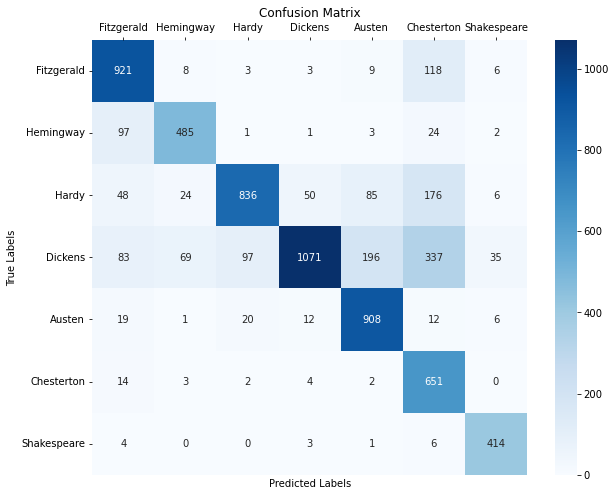

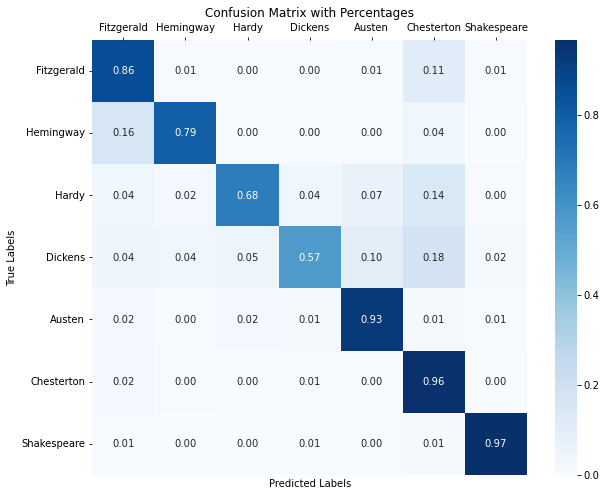

In [97]:
#conf = create_confusion(test_label_small, predictions)
conf = create_confusion(test_label, predictions)
#conf = create_confusion(train_enc_label, predictions_train)
show_confusion(conf)

In [87]:
# Load model weights and analyze predictions
wgt_file = 'bert_multi_bal_weights_epoch2.h5'
wgt_path = 'D:/MIDS/W266/Project/Training/'
bert_model_multi.load_weights(wgt_path+wgt_file)

In [88]:
predictions_train = bert_model_multi.predict(
    [train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask])

60/60 [==============================] - 483s 8s/step


Confusion Matrix:
[[264   0   0   0   0   8   0]
 [ 30 230   0   0   0   0   0]
 [  9   3 217   6  11  28   0]
 [  7   5  16 195  20  29   4]
 [  2   0   0   0 279   1   2]
 [  4   1   0   1   0 265   1]
 [  2   1   0   0   0   0 274]]

Accuracy: 0.9002611

Precision: 0.9949906
Recall: 0.9671333
F1 Score: 0.9808641678283067

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       272
           1       0.96      0.88      0.92       260
           2       0.93      0.79      0.86       274
           3       0.97      0.71      0.82       276
           4       0.90      0.98      0.94       284
           5       0.80      0.97      0.88       272
           6       0.98      0.99      0.98       277

    accuracy                           0.90      1915
   macro avg       0.91      0.90      0.90      1915
weighted avg       0.91      0.90      0.90      1915



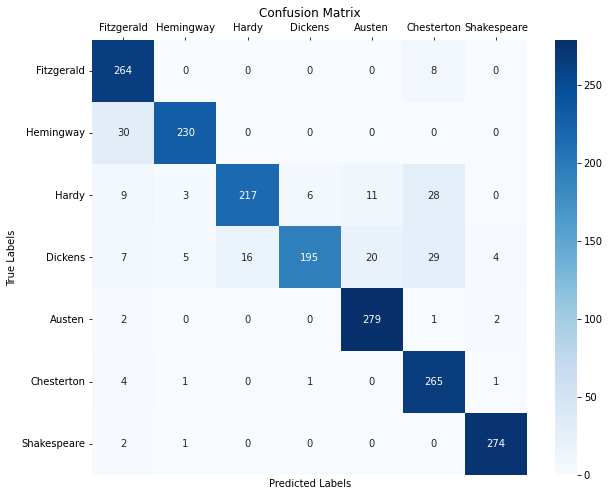

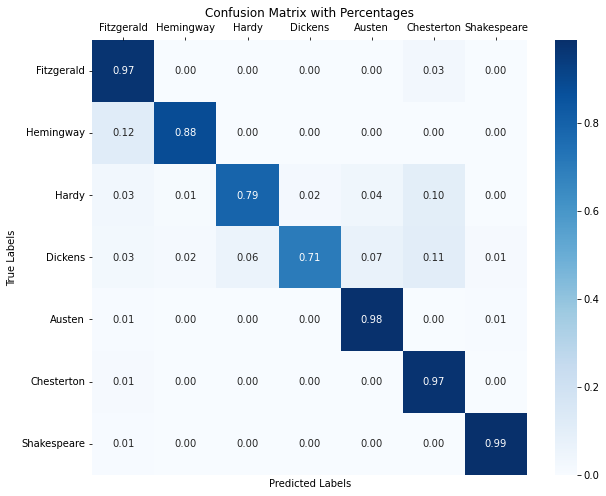

In [89]:
conf = create_confusion(train_enc_label, predictions_train)
show_confusion(conf)

#pred_file = 'predictions_train2.csv'
#pred_path = 'D:/MIDS/W266/Project/Training/'
#np.savetxt(pred_path+pred_file, predictions_train)

In [ ]:
# Unit Test
train_enc_label[0:10]

In [40]:
# Unit Test
train_data[40]

"S'ever, dear Boswell,                                      SAMUEL JOHNSON. BOOK TWO--The Education of a Personage        CHAPTER 1. The Debutante      The time is February."

In [39]:
# Unit Test
train_label[40]

0

In [ ]:
# Unit Test
test_data[4]
len(train_data)

In [ ]:
# Unit Test
test_label[4]
len(predictions_train)

In [90]:
# Find incorrect matches
counter=0
for i in range(len(predictions_train)):
    indx = np.argmax(predictions_train[i],axis=0)
    if train_label[i] != int(indx):
        counter += 1
        print(i)
        print(train_data[i])
        print("test label: " + str(train_label[i]))
        print("pred label: " + str(indx))
        print("***************************")

print("count: " + str(counter))

1
Prize  short-stories—will their authors write our best-sellers of to-morrow? You will enjoy these warm, homespun, American tales, bits of real life  on the open ranch, in crowded tenement or comfortable home, and all with  a healthy undercurrent of humor. I must read them, he thought.
test label: 1
pred label: 0
***************************
5
Mrs. Southcott had recently attained her five-and-twentieth  blessed birthday, of whom a prophetic private in the Life Guards had  heralded the sublime appearance by announcing that arrangements were  made for the swallowing up of London and Westminster. Even the Cock-lane  ghost had been laid only a round dozen of years, after rapping out its  messages, as the spirits of this very year last past (supernaturally  deficient in originality) rapped out theirs. Mere messages in the  earthly order of events had lately come to the English Crown and People,  from a congress of British subjects in America: which, strange  to relate, have proved more impo

In [ ]:
# Find incorrect matches
counter=0
for i in range(len(predictions)):
    indx = np.argmax(predictions[i],axis=0)
    if test_label_small[i] != int(indx):
        counter += 1
        print(i)
        print(test_data_small[i])
        print("test label: " + str(test_label_small[i]))
        print("pred label: " + str(indx))
        print("***************************")
        
print("count: " + str(counter))